In [1]:
# from wandbhelper.util import init_wandb, log_all_plots, log_plot_as_image

# wandb_run_id = init_wandb(run_name="price_match_simulation")
# print(f"Run ID {wandb_run_id}")

In [2]:
import pandas as pd
import pickle
import time

from ml_simulation.dataset_split import customer_split
from ml_simulation.util import HiddenPrints
from ml_features.features import create_features
from ml_training.train_xgb import train_xgb
from ml_simulation.segment import get_nonconverted_customers

from ml_simulation__discount.shift import simulate_discount_conversion_shift, simulate_discount_conversion_shift_all
from ml_simulation__price.shift import simulate_price_conversion_shift, simulate_price_conversion_shift_all
from ml_simulation__budget.shift import simulate_budget_conversion_shift
from ml_simulation__cross_sell.shift import simulate_cross_sell_conversion_shift
from ml_simulation__follow_up.shift import simulate_follow_up_conversion_shift
from ml_simulation__sales_rep.shift import simulate_sales_rep_conversion_shift
    
import warnings
warnings.filterwarnings('ignore')

df_quotes = pd.read_csv('cleaned_quote_data.csv')
df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])

In [3]:
split_result = customer_split(df_quotes)
df_train = split_result['train']
df_sim = get_nonconverted_customers(split_result['simulation'])


SPLIT CUSTOMERS: TRAIN vs SIMULATION: TRAINING SIZE 0.95
Split: 22708 train, 1180 sim customers
Non-converted customers: 923


In [4]:
TRAIN = False

In [5]:
# Model building
if TRAIN:
    with HiddenPrints():
        X_train = create_features(df_train)
    
    y_train = X_train['converted']
    X_train = X_train.drop(['numero_compte', 'converted'], axis=1)
    feature_names = X_train.columns.tolist()
    
    result = train_xgb(X_train, y_train, "simulation_poc")
    model = result['model']
    feature_names = result['features']
    
    print(f"Model trained: {len(feature_names)} features")
else:
    with open('simulation_poc.pkl', 'rb') as file:
        model_data = pickle.load(file)
        model = model_data['model']
        feature_names = model_data['features']


=== DEBUG: ConversionShiftSimulator.run() ===

1. Creating base features...
   Base features shape: (923, 194)
   Number of customers in base: 923

2. Getting base predictions...
   Base predictions stats:
     Min: 0.0271
     Max: 0.7863
     Mean: 0.4001

3. Applying transformation to quotes...

=== DISCOUNT APPLICATION FILTERING ===
Total customers: 923
Customers with no existing discount: 671
Most recent quotes (all customers): 923
Targeted quotes (most recent + no discount history): 671

Discount stats for targeted customers:
  Number of quotes receiving discount: 671
  Total discount amount: €113859.41
  Average discount per targeted quote: €169.69

Remise column update:
  Original remise sum: €-322116.80
  New remise sum: €-435976.21

Price update:
  Total price before: €8584235.44
  Total price after: €8470376.03
  Total discount applied: €113859.41
  Expected discount: €113859.41

4. Creating features on transformed quotes...
   Transformed features shape: (923, 194)
   Numb

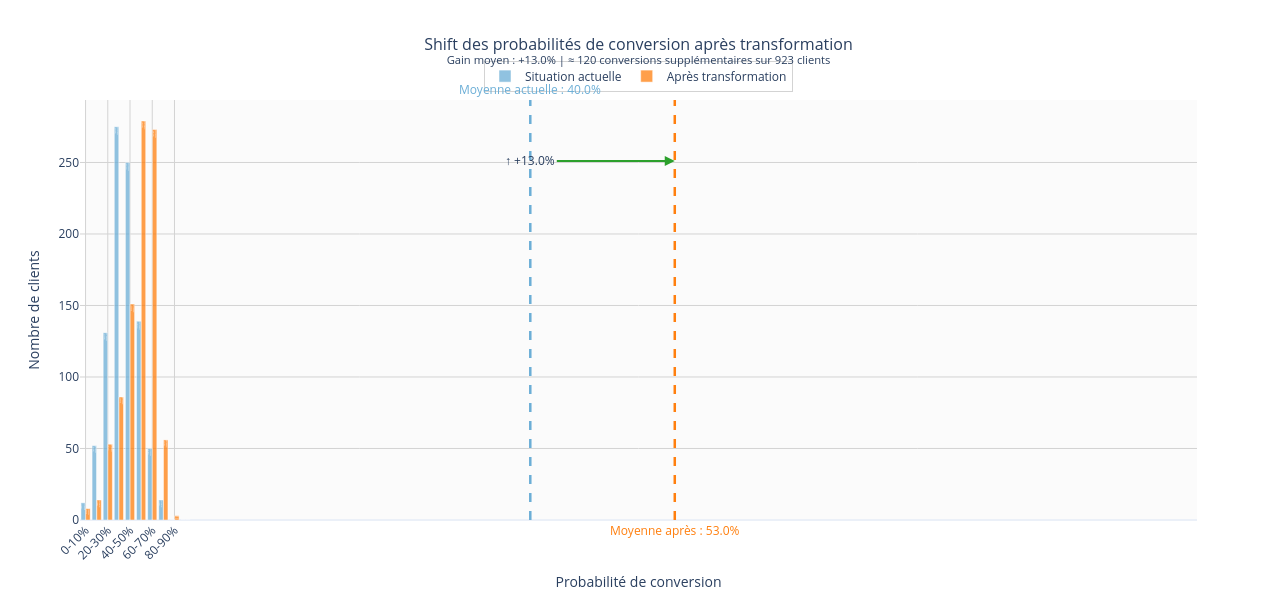

In [6]:
comparison_df = simulate_discount_conversion_shift(df_sim, model, 2.5)

In [7]:
# comparison_df = simulate_discount_conversion_shift_all(df_sim, model)
# print(comparison_df.head())

In [8]:
# comparison_df = simulate_price_conversion_shift(df_sim, model, -0.3)

In [9]:
# comparison_df = simulate_budget_conversion_shift(df_sim, model)

In [10]:
# result = simulate_cross_sell_conversion_shift(
#     df_sim, model, 
#     has_product='Chaudière',
#     add_product='Climatisation'
# )

# result = simulate_cross_sell_conversion_shift(
#     df_sim, model, 
#     has_product='Climatisation',
#     add_product='Pompe à chaleur'
# )

# result = simulate_cross_sell_conversion_shift(
#     df_sim, model, 
#     has_product='Chaudière',
#     add_product='Pompe à chaleur'
# )

# result = simulate_cross_sell_conversion_shift(
#     df_sim, model, 
#     has_product='Pompe à chaleur',
#     add_product='Poêle'
# )

In [11]:
# comparison_df = simulate_follow_up_conversion_shift(df_sim, model)

# products = ['Climatisation', 'Pompe à chaleur', 'Chaudière', 'ECS : Chauffe-eau ou adoucisseur']

# for product in products:
#     result = simulate_follow_up_conversion_shift(df_sim, model, new_product=product)
#     print(f"\n{product}: Lift = {result['new_prediction'].mean() - result['base_prediction'].mean():+.4f}")

In [12]:
# comparison_df = simulate_sales_rep_conversion_shift(df_sim, model)